In [98]:
import sys

sys.path.append("..")

In [99]:
import ast
import math
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.util import *

tqdm.pandas()

In [100]:
df = pd.read_csv("../out/rec9.csv")
df = df.set_index("user_id", drop=True)
list_cols = [
    "target_items",
    "before_rerank_rec",
    "before_rerank_rec_value",
    "after_rerank_rec",
    "after_rerank_rec_value",
]

for col in list_cols:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))

In [101]:
movie_df = pd.read_csv(
    "../data/ml-25m/movies.csv", dtype={"userId": str, "movieId": str}
)
movie_df = movie_df.set_index("movieId")
movie_df.genres = movie_df.genres.progress_apply(lambda s: s.split("|"))
movie_df["year"] = movie_df.title.str.extract("\((\d{4})\)", expand=True)
movie_df = pd.concat(
    [movie_df, pd.get_dummies(movie_df.genres.explode()).groupby(level=0).sum()], axis=1
)

all_genres = movie_df.genres.explode().unique().tolist()
row_sum = movie_df[all_genres].sum(axis=1)
for genre in all_genres:
    movie_df[genre] /= row_sum

genre_vec = {
    movie_id: vec for movie_id, vec in zip(movie_df.index, movie_df[all_genres].values)
}

100%|██████████| 62423/62423 [00:00<00:00, 1405531.69it/s]


In [104]:
rating_df = pd.read_csv("../data/ml-25m/ratings.csv")
prefs = (
    rating_df.groupby("movieId").userId.agg(set).to_dict(collections.defaultdict(set))
)
prefs2 = {}


def f_pref2(item_i: int, item_j: int) -> int:
    if (item_i, item_j) in prefs2:
        return prefs2[item_i, item_j]
    prefs2[item_i, item_j] = max(len(prefs[item_i] & prefs[item_j]), 1)
    return prefs2[item_i, item_j]


def calc_genre_diversity(
    target_items: list[int], recommendation: list[int], k: int
) -> float:
    return np.mean([genre_vec[item] for item in recommendation[:k]], axis=0).var()


def calc_genre_diversity2(
    target_items: list[int], recommendation: list[int], k: int
) -> float:
    div_sum = 0.0
    for i, item_i in enumerate(recommendation[:k]):
        for j, item_j in enumerate(recommendation[:k]):
            if i == j:
                continue
            div_sum += ((genre_vec[item_i] - genre_vec[item_j]) ** 2).sum()
    div_sum /= k * (k - 1)
    return math.sqrt(div_sum)


def calc_pref_diversity(
    target_items: list[int], recommendation: list[int], k: int
) -> float:
    div_sum = 0.0
    for i, item_i in enumerate(recommendation[:k]):
        for j, item_j in enumerate(recommendation[:k]):
            if i == j:
                continue
            div_sum += (
                math.sqrt(len(prefs[item_i]))
                * math.sqrt(len(prefs[item_j]))
                / f_pref2(item_i, item_j)
            )
    div_sum /= k * (k - 1)
    return math.sqrt(div_sum)

In [105]:
metrics = [
    ("HR", calc_hit_ratio),
    ("Precision", calc_precision),
    ("Recall", calc_recall),
    ("MRR", calc_mrr),
    ("MAP", calc_map),
    ("ILS(Genre)", calc_genre_diversity),
    # ("ILS(Genre)(2)", calc_genre_diversity2),
    ("PrefDiversity", calc_pref_diversity),
]

ks = list(range(5, 31))
recs = ["before_rerank_rec", "after_rerank_rec"]


df = pd.concat(
    [
        df,
        pd.concat(
            [
                df.apply(
                    lambda row: metric_fn(row["target_items"], row[rec], k),
                    axis=1,
                ).rename(f"{rec}_{metric_name}@{k}")
                for metric_name, metric_fn in metrics
                for k in tqdm(ks)
                for rec in recs
            ],
            axis=1,
        ),
    ],
    axis=1,
)

100%|██████████| 26/26 [00:38<00:00,  1.48s/it]


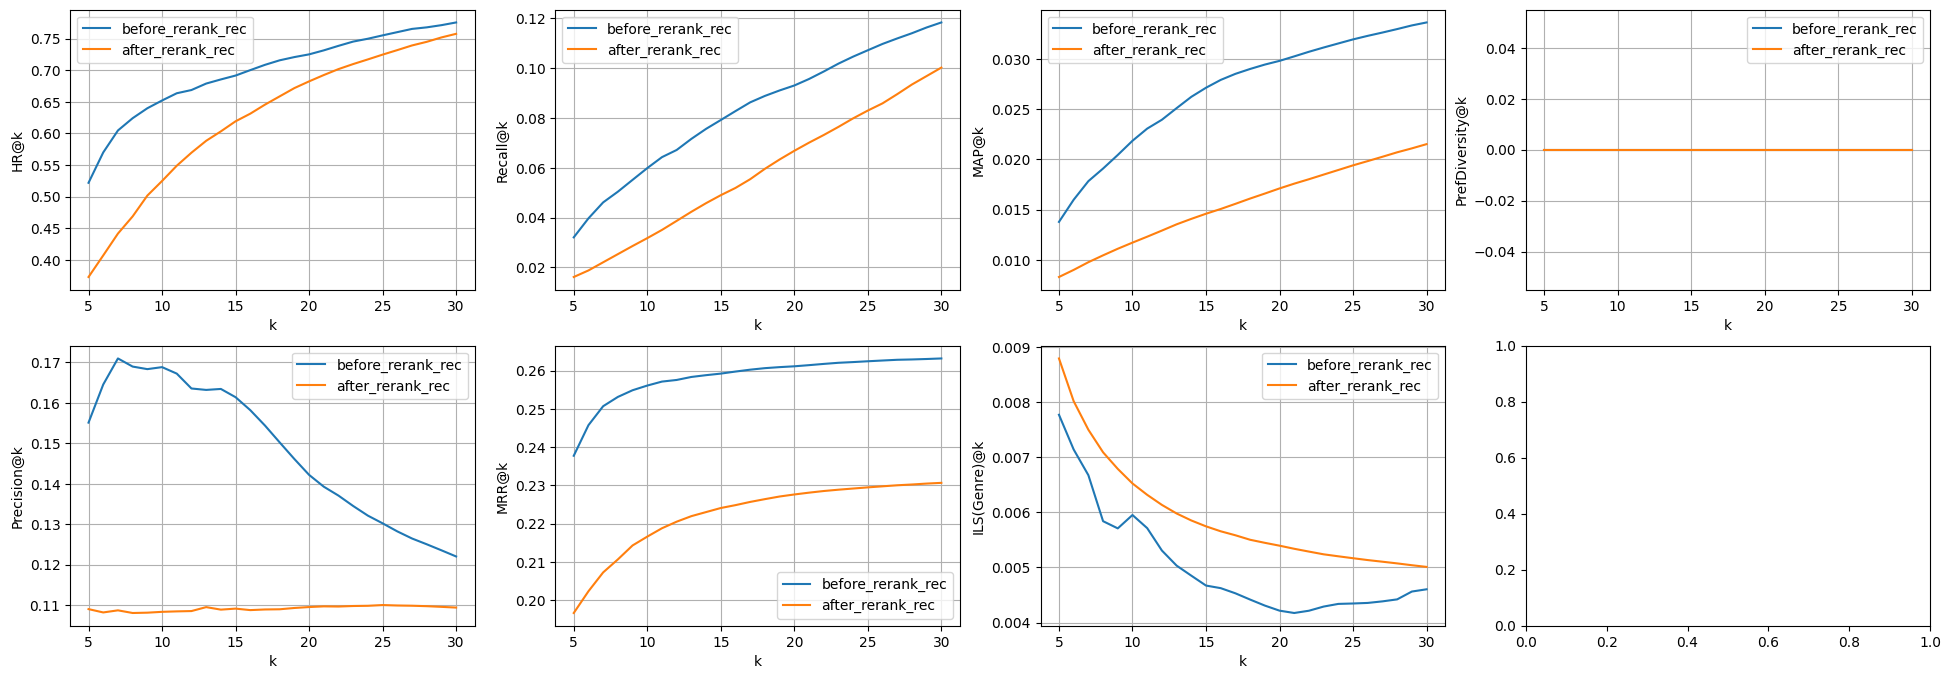

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))

for i, (metric_name, _) in enumerate(metrics):
    for rec in recs:
        metric_values = [df[f"{rec}_{metric_name}@{k}"].mean() for k in ks]
        axes[i % 2, i // 2].plot(ks, metric_values, label=rec)
    axes[i % 2, i // 2].set_xlabel("k")
    axes[i % 2, i // 2].set_ylabel(f"{metric_name}@k")
    axes[i % 2, i // 2].grid()
    axes[i % 2, i // 2].legend()

plt.show()

96/4893


year
2016    26
2017    12
2015    10
2014     8
2001     4
2012     4
2009     4
2010     3
2003     3
2002     3
2006     2
2008     2
2013     2
1994     2
1984     1
1980     1
1968     1
1982     1
1997     1
1999     1
Name: count, dtype: int64

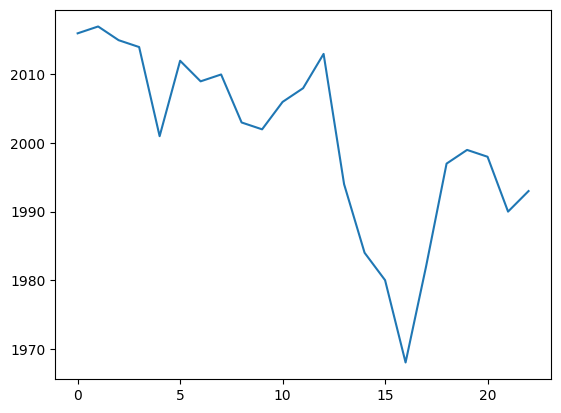

In [107]:
st = set()
for v in df.before_rerank_rec:
    for e in v:
        st.add(e)
print(f"{len(st)}/{len(df)}")
a = pd.merge(pd.Series(list(st)).rename("movieId").to_frame(), movie_df, on="movieId", how="left")
display(a.year.value_counts()[:20])
plt.plot(list(map(int, a.year.value_counts().keys())))

In [ ]:
a

,movieId,title,genres,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,115713,Ex Machina (2015),"[Drama, Sci-Fi, Thriller]",2015,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.000000,0.0
1,122882,Mad Max: Fury Road (2015),"[Action, Adventure, Sci-Fi, Thriller]",2015,0.0,0.250000,0.250000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.250000,0.000000,0.0
2,152077,10 Cloverfield Lane (2016),[Thriller],2016,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0
3,152081,Zootopia (2016),"[Action, Adventure, Animation, Children, Comedy]",2016,0.0,0.200000,0.200000,0.2,0.2,0.2,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",1965,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,135143,Fantastic Beasts and Where to Find Them (2016),[Fantasy],2016,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
123,174055,Dunkirk (2017),"[Action, Drama, Thriller, War]",2017,0.0,0.250000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.250000,0.250000,0.0
124,7153,"Lord of the Rings: The Return of the King, The...","[Action, Adventure, Drama, Fantasy]",2003,0.0,0.250000,0.250000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
125,134130,The Martian (2015),"[Adventure, Drama, Sci-Fi]",2015,0.0,0.000000,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.0
